In [756]:
import numpy as np
import pylab as plt
from scipy.linalg import logm
import corner
from matplotlib.patches import Ellipse
plt.style.use('classic')
%matplotlib inline

# 1
I use this equation to describe each object which i assume to be circularly Gaussian shaped

$\tau((x,y);[X,Y,A,R]) = Aexp[-\frac{(x-X)^2+(y-Y)^2}{2R^2}]$  (reference: M.P Hobson and C. McLachlan paper)

In [436]:
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    return A*np.exp(-term1)

In [614]:
# Position x,y
x = np.linspace(0,50,200)
y = np.linspace(0,50,200)

# One Source at  X=5 , Y=5 , (R=100 spatial extent ), A=0.96 amplitude
X = np.random.normal(5,1,200)
Y = np.random.normal(5,1,200)
R = np.random.normal(100,1,200)
A = np.random.normal(0.96,1,200)

source1_template = tau(x,y,X,Y,R,A)

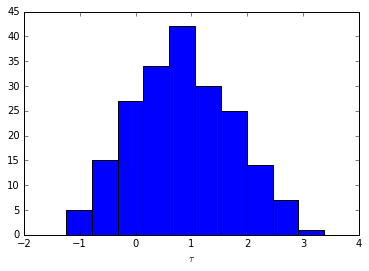

In [626]:
plt.hist(source1_template);
plt.xlabel(r'$\tau$')
plt.show()

# 2
I then create a 2d histogram and weight each pixel with the corresponding template value.

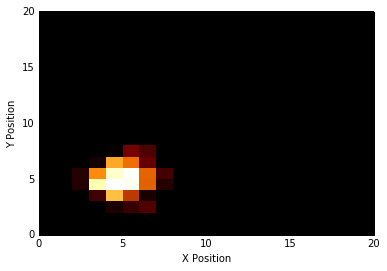

In [631]:
plt.hist2d(X,Y,bins=20,cmap='afmhot',range=np.array([(0, 20), (0, 20)]),weights=source1_template);
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

# 3

 - I then define my Model (Which is the template equation defined in 1) and my Likelihood (Gaussian function)
 - So my data in this case is the simulated template values in part 1 


In [620]:
def Model(x,y,X1,Y1,A1,R1):  #Model
    # Define normal distributions centred at the given values
    X = np.random.normal(X1,1,200)
    Y = np.random.normal(Y1,1,200)
    R = np.random.normal(R1,1,200)
    A = np.random.normal(A1,1,200)
    
    #I then calculate the corresponding template values for each sample ( should this be a single value or not?)
    source_template = tau(x,y,X1,Y1,R1,A1)
    return source_template


In [641]:
def logLike(X1,Y1,A1,R1): #Likelihood function
    
    data = source1_template
    mu = Model(x,y,X1,Y1,A1,R1)
    LogL = -(len(data)/2)*np.log(2*np.pi)-(1/2)*(np.sum((data-mu)**2))
    
    return LogL 

In [750]:
#Initial values  
theta = [3,6,0.6,65]   # Random start sample
interval = [(2,7),(2,7),(0.5,1),(60,110)]  #Unifotm prior on parameters
nmcmc_runs = 100000                      #Number  of mcmc runs
samples_mcmc = np.zeros((nmcmc_runs,4))  #Store samples
sigma = [1,1,1,1]                       # sigma for proposal jump

In [751]:
for i in range(nmcmc_samples):
    theta_new = theta + sigma*np.random.multivariate_normal([0,0,0,0],np.identity(4))  # Proposed new sample 
    
    while True:  #check is sample lies within flat prior
        add = 0
        for j in range(4):
            if interval[j][0] <= theta_new[j] <= interval[j][1]:
                add  += 1
        if add == 4: #if true Prior = 1
            Prior = 1
            break
            
        else:          #If false Prior = 0
            Prior = 0
            
            break
            
    
    logLikelihood_proposed = logLike(theta_new[0],theta_new[1],theta_new[2],theta_new[3])*Prior #Proposed Liklelihood
    logLikelihood_current = logLike(theta[0],theta[1],theta[2],theta[3])                        #Current likelihood
    
    alpha = logLikelihood_proposed/logLikelihood_current 
    
    if alpha >= 1:            #Accept if new sample has higher likelihood
        theta = theta_new
        naccepted += 1
    else:                   # If not, randomly reject or accept sample 
        u = np.random.uniform() # Generate random uniform value between u~[0,1]
        if u <= alpha :           #if alpha is larger than u, accept sample
            theta = theta_new
            naccepted +=1
        else:                #if not reject sample
            theta = theta    
    
    samples_mcmc[i,:] = theta_new   #Store samples
    

In [752]:
naccepted  # No. of Accepted samples

31997

## 4 Posterior Results

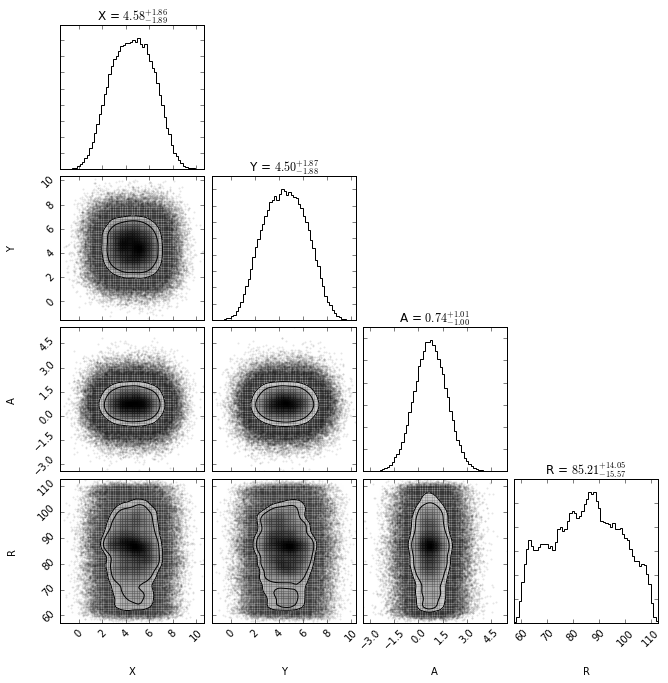

In [782]:
corner.corner(samples_mcmc,labels=['X','Y','A','R'],show_titles=True,bins=60,levels=[0.5,0.65],smooth=1.7,max_n_ticks=7);


## 5

I decided to plot an ellipse centred at the estimated position of the source with arbitrary height and width.

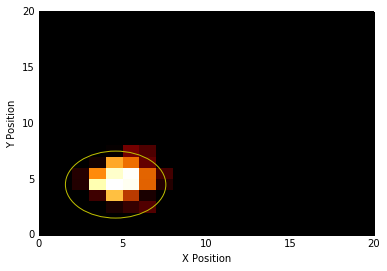

In [786]:
plt.figure()
ax = plt.gca()

ellipse = Ellipse(xy=(4.58,4.5),width=6,height=6,facecolor='None',edgecolor='y')
ax.add_patch(ellipse)
ax.hist2d(X,Y,bins=20,cmap='afmhot',range=np.array([(0, 20), (0, 20)]),weights=source1_template);

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

    X_estimate = 4.58     X_real = 5
    Y_estimate = 4.50     Y_real = 5
    A_estimate = 0.74     A_real = 0.96
    R_estimate = 85.2     R_real = 100

In [803]:
print('X_err = {},\nY_err = {},\nA_err= {},\nR_err = {}'.format(np.std(samples_mcmc[:,0]),np.std(samples_mcmc[:,1]),np.std(samples_mcmc[:,2]),np.std(samples_mcmc[:,3])))

X_err = 1.766799974819376,
Y_err = 1.767979781647268,
A_err= 1.0124765056418827,
R_err = 13.05245141959363
